<a href="https://colab.research.google.com/github/NuriaSarochar/Python/blob/main/Google%20Merchandise%20Store%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Analytics Dataframe Classification

This is a sample of the dataset of [Google Analytics from the Google Merchandise Store](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089#zippy=%2Cin-this-article). Its columns have information on the activity on this site of different users.
* *fullVisitorId*: The unique visitor ID.
* *visitNumber*: The session number for this user. If this is the first session, then this is set to 1.
* *date*: The date of the session in YYYYMMDD format.
* *bounces*: For a bounced session, the value is 1, otherwise it is null. A bounced session is when there were no interaction from the user.
* *hits*: Total number of hits within the session.
* *pageviews*: 	Total number of pageviews within the session.
* *timeOnSite*: Total time of the session expressed in seconds.
* *transactionRevenue*: Total transaction revenue.
* *transactions*: Total number of ecommerce transactions within the session.
* *source*: The source of the traffic source. Could be the name of the search engine, the referring hostname, or a value of the utm_source URL parameter.
* *channelGrouping*: The Default Channel Group associated with an end user's session for this View. Groups sources into channels.
* *browser*: The browser used (e.g., "Chrome" or "Firefox").
* *deviceCategory*: The type of device (Mobile, Tablet, Desktop).
* *country*: The country from which sessions originated, based on IP address.
* *city*: Users' city, derived from their IP addresses or Geographical IDs.

In this proyect, it is going to be created a model that predicts wich user is going to buy on the page according with its interaction with the site.

# Data Reading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, precision_score, \
recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
#Data is saved in google drive

url = 'https://drive.google.com/uc?id=1fobWNNFDuAWdRrDcDkpDxhkRH-q99Yz6'
data = pd.read_csv(url, parse_dates=['date'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory Data Analysis

In [3]:
def plot_labels(xlabel, ylabel, title):
    #Puts labels and title in the plots
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [4]:
def group_cat(data, column):
  #Groups dataframe by some categorical column 
  # orders by frequency of appearence
  # and shows the firts 10 more usual categories.
  categories, times = np.unique(data[column], return_counts = True)
  group= pd.DataFrame({column: categories,
                              'count': times}).sort_values('count', ascending = False)
  group['percentage'] = group['count'] / data.shape[0]

  print(f'There are {group.shape[0]} different {column}.')
  print('***'*10)
  print(group.head(10))

In [5]:
print(f'El dataset cuenta con {data.shape[0]} registros y {data.shape[1]} columnas.')
data.info()#Table to see missing values and data type

El dataset cuenta con 392892 registros y 15 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fullVisitorID       392892 non-null  object        
 1   visitNumber         392892 non-null  int64         
 2   date                392892 non-null  datetime64[ns]
 3   bounces             195964 non-null  float64       
 4   hits                392892 non-null  int64         
 5   pageviews           392856 non-null  float64       
 6   timeOnSite          196399 non-null  float64       
 7   transactionRevenue  5277 non-null    float64       
 8   transactions        5277 non-null    float64       
 9   source              392892 non-null  object        
 10  channelGrouping     392892 non-null  object        
 11  browser             392892 non-null  object        
 12  deviceCategory      392892 non-n

In [6]:
data.describe()

,visitNumber,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions
count,392892.000000,195964.0,392892.000000,392856.000000,196399.000000,5277.000000,5277.000000
mean,2.361198,1.0,4.414065,3.771015,276.837127,162.838217,1.047754
std,10.158865,0.0,8.555069,6.414908,485.765241,898.877951,0.571294
min,1.000000,1.0,1.000000,1.000000,1.000000,2.200000,1.000000
25%,1.000000,1.0,1.000000,1.000000,33.000000,29.180000,1.000000
50%,1.000000,1.0,2.000000,1.000000,94.000000,53.950000,1.000000
75%,1.000000,1.0,4.000000,4.000000,287.000000,114.530000,1.000000
max,389.000000,1.0,500.000000,466.000000,12136.000000,47082.060000,25.000000


In [7]:
# Generates a new column with 0 if there weren't a transaction (user didn't buy)
# and 1 if the user did.
data['bought'] = np.where(data['transactions'].isnull(), 0,1)

### Numerical Features

#### Visit Number

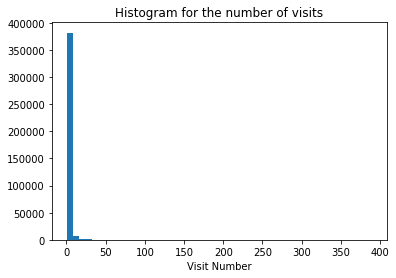

In [8]:
plt.hist(data['visitNumber'],bins = 50)
plot_labels('Visit Number','','Histogram for the number of visits')

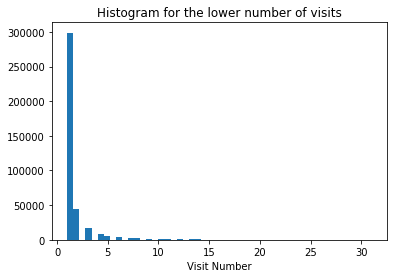

In [9]:
lower_visit_number = data[data['visitNumber'] < 32]

plt.hist(lower_visit_number['visitNumber'],bins = 50)
plot_labels('Visit Number','','Histogram for the lower number of visits')

In [10]:
# What happends with the number of visits bewteen 20 and the max?
num_buyers_many_visits = data[(data['visitNumber'] > 32)  & (data['transactions'] > 0)].shape[0]
print(f'There are {num_buyers_many_visits} users with nummber of visits greater than 32 that were buyers.')

There are 66 users with nummber of visits greater than 32 that were buyers.


Most of the users visit 1 time the site, but even less users visit more than 32 times (the mean plus two standard deviations), 66 of those lasts made a transactions (are buyers).

#### Hits

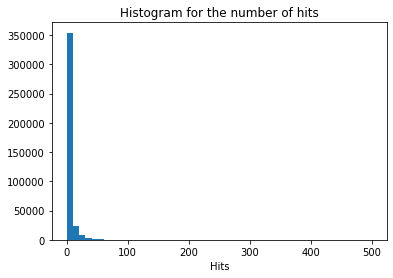

In [11]:
plt.hist(data['hits'],bins = 50)
plot_labels('Hits','','Histogram for the number of hits')

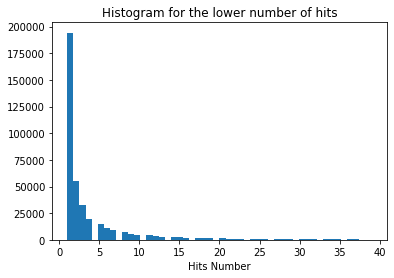

In [12]:
lower_hits_number = data[data['hits'] < 40]

plt.hist(lower_hits_number['hits'],bins = 50)
plot_labels('Hits Number','','Histogram for the lower number of hits')

In [13]:
# What happends with the number of hits greater than 40?
num_many_hits = data[(data['hits'] > 40)].shape[0]
print(f'There are {num_many_hits} users with number of hits greater than 40.')
num_buyers_many_hits = data[(data['hits'] > 40)  & (data['transactions'] > 0)].shape[0]
print(f'There are {num_buyers_many_hits} users with number of hits greater than 40 that were buyers.')
num_buyers_little_hits = data[(data['hits'] < 40)  & (data['transactions'].isnull())].shape[0]
print(f'There are {num_buyers_little_hits} users with number of hits less than 40 that were not buyers.')

There are 3853 users with number of hits greater than 40.
There are 1244 users with number of hits greater than 40 that were buyers.
There are 384810 users with number of hits less than 40 that were not buyers.


Most users hits less times, less interacction with the page. But lots of the ones that hits many times are buyers, while most of the ones that hits less times aren't buyers.

#### Page Views

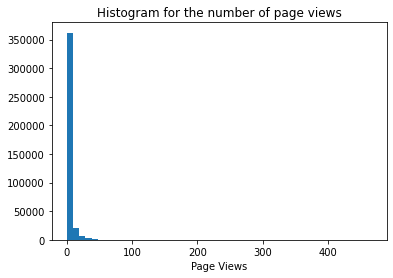

In [14]:
plt.hist(data['pageviews'],bins = 50)
plot_labels('Page Views','','Histogram for the number of page views')

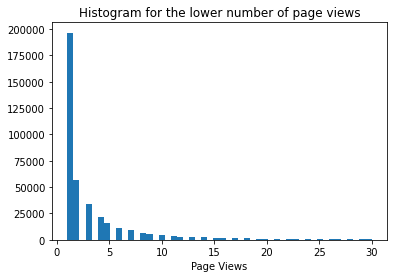

In [15]:
lower_page_views_number = data[data['pageviews'] < 31]

plt.hist(lower_page_views_number['pageviews'],bins = 50)
plot_labels('Page Views','','Histogram for the lower number of page views')

In [16]:
# What happends with the number of page views greater than 31?
num_many_page_views = data[(data['pageviews'] > 31)].shape[0]
print(f'There are {num_many_page_views} users with number of page views greater than 31.')
num_buyers_many_page_views = data[(data['pageviews'] > 31)  & (data['transactions'] > 0)].shape[0]
print(f'There are {num_buyers_many_page_views} users with number of page views greater than 31 that were buyers.')
num_buyers_little_page_views = data[(data['pageviews'] < 31)  & (data['transactions'].isnull())].shape[0]
print(f'There are {num_buyers_little_page_views} users with number of page views less than 31 that were not buyers.')

There are 3567 users with number of page views greater than 31.
There are 1238 users with number of page views greater than 31 that were buyers.
There are 385019 users with number of page views less than 31 that were not buyers.


Most users view pages less times. But lots of the ones that view many pages are buyers, while most of the ones that view less pages aren't buyers.

#### Time on Site

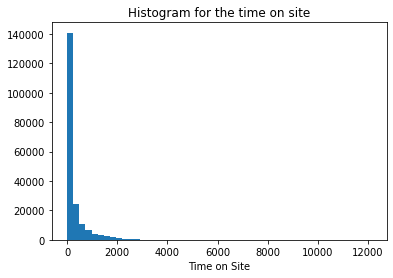

In [17]:
plt.hist(data['timeOnSite'],bins = 50)
plot_labels('Time on Site','','Histogram for the time on site')

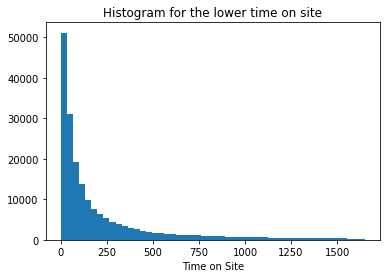

In [18]:
lower_time_on_site = data[data['timeOnSite'] < 1653]

plt.hist(lower_time_on_site['timeOnSite'],bins = 50)
plot_labels('Time on Site','','Histogram for the lower time on site')

In [19]:
# What happends with time on site longer than 1653? (27,55 minutes)
num_long_time_on_site = data[(data['timeOnSite'] > 1653)].shape[0]
print(f'There are {num_long_time_on_site} users with time on site greater than {1653/60} minutes.')
num_buyers_long_time_on_site = data[(data['timeOnSite'] > 1653)  & (data['transactions'] > 0)].shape[0]
print(f'There are {num_buyers_long_time_on_site} users with time on site longer than {1653/60} minutes that were buyers.')
num_buyers_short_time_on_site = data[(data['timeOnSite'] < 1653)  & (data['transactions'].isnull())].shape[0]
print(f'There are {num_buyers_short_time_on_site} users with time on site shorter than {1653/60} minutes that were not buyers.')

There are 5230 users with time on site greater than 27.55 minutes.
There are 834 users with time on site longer than 27.55 minutes that were buyers.
There are 186714 users with time on site shorter than 27.55 minutes that were not buyers.


Most users spend less time on site. But lots of the ones that spend more time are buyers, while most of the ones that doesn't, aren't buyers.

#### Transactions Revenue

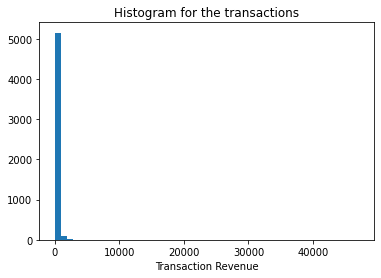

In [20]:
#Histogram for the transactions
plt.hist(data['transactionRevenue'],bins = 50)
plot_labels('Transaction Revenue','','Histogram for the transactions')

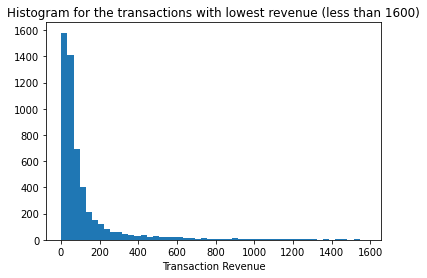

In [21]:
#Histogram for the transactions with lowest revenue (less than 1600)
transactions_low = data[data['transactionRevenue'] < 1600]['transactionRevenue']
plt.hist(transactions_low,bins = 50)
plot_labels('Transaction Revenue','','Histogram for the transactions with lowest revenue (less than 1600)')

Small amount of revenues are more common than bigger amounts. But, there are a few with really important amounts.

#### Transactions

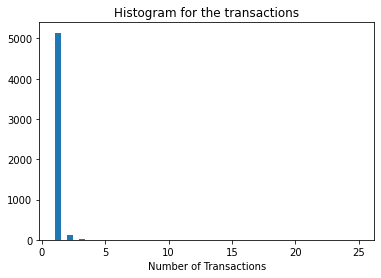

In [22]:
#Histogram for the transactions
plt.hist(data['transactions'],bins = 50)
plot_labels('Number of Transactions','','Histogram for the transactions')

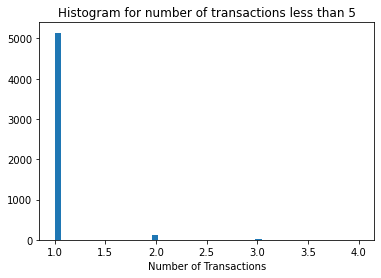

In [23]:

num_transactions_low = data[data['transactions'] < 5]
plt.hist(num_transactions_low['transactions'],bins = 50)
plot_labels('Number of Transactions','','Histogram for number of transactions less than 5')

In [24]:
more_than_one_transaction = data[data['transactions'] > 1].shape[0]
print(f'There are {more_than_one_transaction} number of user that made more than one transaction')

more_than_two_transaction = data[data['transactions'] > 2].shape[0]
print(f'There are {more_than_two_transaction} number of user that made more than two transactions')

There are 136 number of user that made more than one transaction
There are 26 number of user that made more than two transactions


Most users that bought on the site made only one transaction (bought only one time). Only 136 users bought more than once, and only 26 made more.

#### Number of transactions and its revenue


In [25]:
# Buyers are the users that made 1 transaction or more
buyers = data[data['transactions'] > 0]
print(f'There are {buyers.shape[0]} users that made transactions.')

There are 5277 users that made transactions.


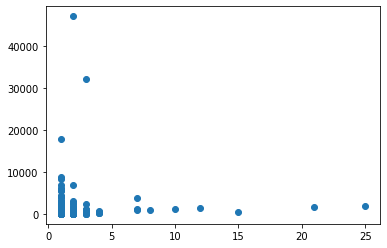

In [26]:
xi = buyers['transactions']
yi = buyers['transactionRevenue']
plt.scatter(xi,yi)

In [27]:
columns_show = ['visitNumber', 'hits', 'pageviews', 'timeOnSite', 'transactionRevenue', 'transactions']

buyers[columns_show].sort_values('transactionRevenue', ascending = False).head(10)

,visitNumber,hits,pageviews,timeOnSite,transactionRevenue,transactions
157267,243,58,40.0,1367.0,47082.06,2.0
51298,258,77,56.0,2354.0,32153.82,3.0
187805,181,91,64.0,2896.0,17859.50,1.0
357148,237,50,39.0,2711.0,8680.83,1.0
192987,43,32,22.0,1614.0,8257.80,1.0
232053,3,111,66.0,1593.0,6969.70,2.0
116626,245,227,151.0,5466.0,6831.96,1.0
16489,6,31,23.0,1281.0,6252.75,1.0
318570,5,82,52.0,1898.0,5608.40,1.0
54598,31,26,24.0,576.0,5501.00,1.0


In [28]:
buyers[columns_show].sort_values('transactions', ascending = False).head(10)

,visitNumber,hits,pageviews,timeOnSite,transactionRevenue,transactions
10915,1,500,466.0,7013.0,1938.09,25.0
10914,1,445,358.0,7435.0,1576.33,21.0
318573,2,308,139.0,3595.0,382.00,15.0
351009,1,216,176.0,3465.0,1319.63,12.0
10913,2,238,182.0,9300.0,1223.57,10.0
392891,4,205,179.0,4195.0,901.71,8.0
106288,1,386,343.0,6427.0,3775.80,7.0
148447,1,100,87.0,1743.0,951.70,7.0
92962,1,500,400.0,8872.0,1209.64,7.0
249223,10,122,112.0,4052.0,480.85,4.0


Big amounts of revenue are related with less number of transactions but many number of visits. All that revenue was made in one or two transactions. On the other hand, big numbers of transactions are related with short number of visits. Grater number of hits, page views and also longer time on site and biger transactions revenue. 

### Categorical Features 

#### Source

In [29]:
group_cat(data,'source')

There are 210 different source.
******************************
                   source   count  percentage
0                (direct)  167390    0.426046
64                 google  141404    0.359906
209           youtube.com   43860    0.111634
8    analytics.google.com    8887    0.022619
3                Partners    7928    0.020179
78             google.com    2532    0.006445
44                    dfa    2411    0.006137
128        m.facebook.com    2117    0.005388
184      sites.google.com    1202    0.003059
166            reddit.com    1183    0.003011


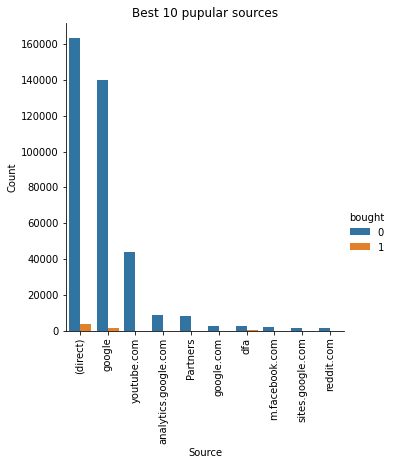

In [30]:
sns.catplot(
    x = 'source',
    data =  data,
    kind="count",
    order = data['source'].value_counts().iloc[:10].index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('Source','Count','Best 10 pupular sources')

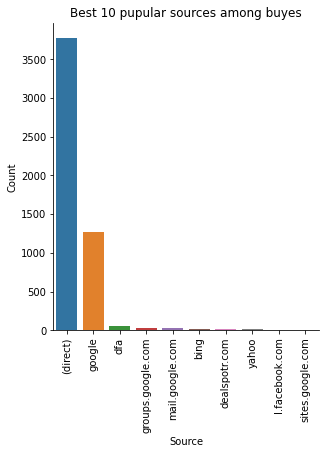

In [31]:
sns.catplot(
    x = 'source',
    data =  buyers,
    kind="count",
    order = buyers['source'].value_counts().iloc[:10].index)
plt.xticks(rotation= 90)
plot_labels('Source','Count','Best 10 pupular sources among buyes')

The first categorical feature that is being study is Source. This feature has 210 different categories, and only the firsts three are more important, because they appear with more frequency. These are '(direct)', 'google' and 'youtube'. In the buyers dataframe, the most frequent sources are '(direct)' and 'google', the rest are less frequent and important.

#### Channel Grouping
Is the grouping of sources.

In [32]:
group_cat(data, 'channelGrouping')

There are 8 different channelGrouping.
******************************
  channelGrouping   count  percentage
4  Organic Search  195434    0.497424
2          Direct   73723    0.187642
7          Social   52174    0.132795
6        Referral   48877    0.124403
5     Paid Search   12075    0.030734
1      Affiliates    7921    0.020161
3         Display    2575    0.006554
0         (Other)     113    0.000288


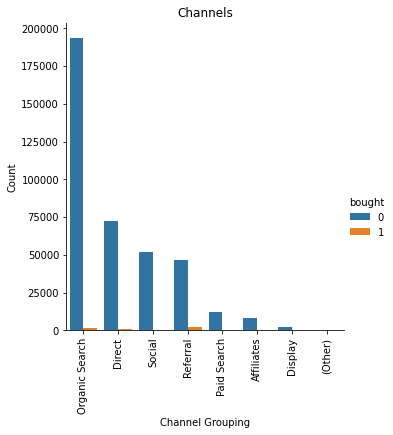

In [33]:
sns.catplot(
    x = 'channelGrouping',
    data =  data,
    kind="count",
    order = data['channelGrouping'].value_counts().index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('Channel Grouping','Count','Channels')

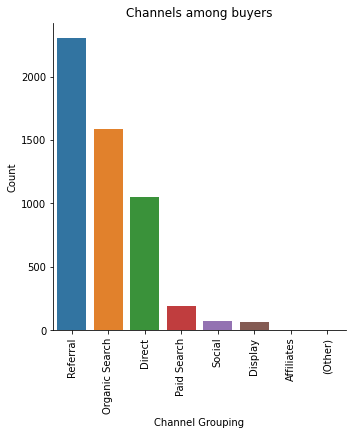

In [34]:
sns.catplot(
    x = 'channelGrouping',
    data =  buyers,
    kind="count",
    order = buyers['channelGrouping'].value_counts().index)
plt.xticks(rotation= 90)
plot_labels('Channel Grouping','Count','Channels among buyers')

Channel grouping is a feature that groups the different sources in less amount of categories. As can be seen in the graphics, there are a few with small frequency of appearence, and the frequencies changes from the general dataframe and the only buyers. The most frequent channel is 'organic search' in the dataframe, but in the buyers dataframe it is 'Referral', wich was the fourth in the first dataframe. 

#### Browser

In [35]:
group_cat(data, 'browser')

There are 39 different browser.
******************************
              browser   count  percentage
9              Chrome  279456    0.711279
30             Safari   61638    0.156883
14            Firefox   17834    0.045392
16  Internet Explorer    9513    0.024213
4     Android Webview    6225    0.015844
13               Edge    4976    0.012665
31    Safari (in-app)    4199    0.010687
27         Opera Mini    3075    0.007827
26              Opera    2037    0.005185
34         UC Browser    1390    0.003538


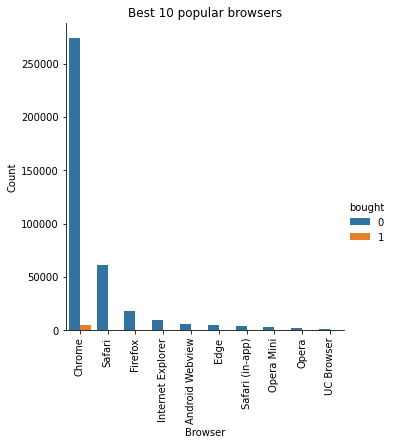

In [36]:
sns.catplot(
    x = 'browser',
    data =  data,
    kind="count",
    order = data['browser'].value_counts().iloc[:10].index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('Browser','Count','Best 10 popular browsers')

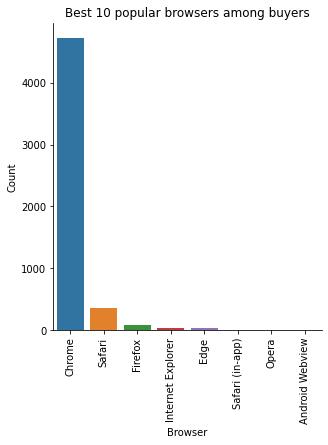

In [37]:
sns.catplot(
    x = 'browser',
    data =  buyers,
    kind="count",
    order = buyers['browser'].value_counts().iloc[:10].index)
plt.xticks(rotation= 90)
plot_labels('Browser','Count','Best 10 popular browsers among buyers')

It can be seen here that Chrome is the most popular browser in the store, and also between the buyers. This makes sense because people that buys google merchandising could be the same that uses chrome as their browser.

#### Device Category

In [38]:
group_cat(data, 'deviceCategory')

There are 3 different deviceCategory.
******************************
  deviceCategory   count  percentage
0        desktop  267370    0.680518
1         mobile  110200    0.280484
2         tablet   15322    0.038998


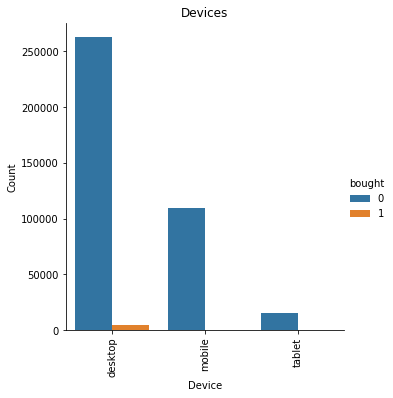

In [39]:
sns.catplot(
    x = 'deviceCategory',
    data =  data,
    kind="count",
    order = data['deviceCategory'].value_counts().index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('Device','Count','Devices')

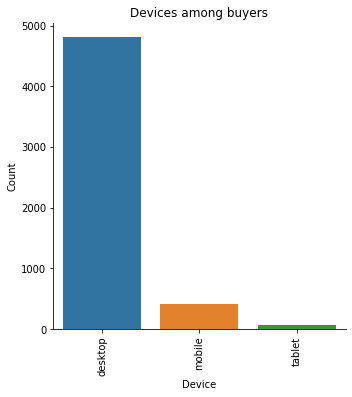

In [40]:
sns.catplot(
    x = 'deviceCategory',
    data =  buyers,
    kind="count",
    order = buyers['deviceCategory'].value_counts().index)
plt.xticks(rotation= 90)
plot_labels('Device','Count','Devices among buyers')

This category feature has only three categories, the most popular in both dataframes, the geneal and the only buyers, is desktop.

#### Country

In [41]:
group_cat(data, 'country')

There are 213 different country.
******************************
            country   count  percentage
203   United States  172224    0.438349
89            India   24361    0.062004
202  United Kingdom   19274    0.049057
35           Canada   12308    0.031327
72          Germany   10467    0.026641
98            Japan    9669    0.024610
66           France    8439    0.021479
175           Spain    6502    0.016549
11        Australia    6412    0.016320
187          Taiwan    6177    0.015722


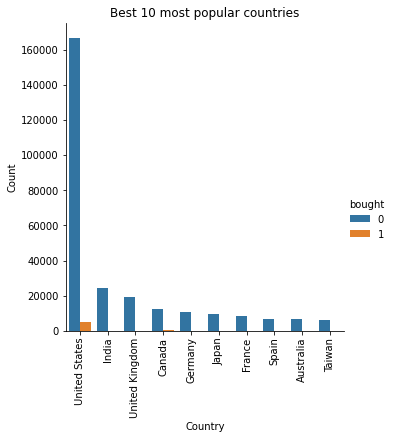

In [42]:
sns.catplot(
    x = 'country',
    data =  data,
    kind="count",
    order = data['country'].value_counts().iloc[:10].index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('Country','Count','Best 10 most popular countries')

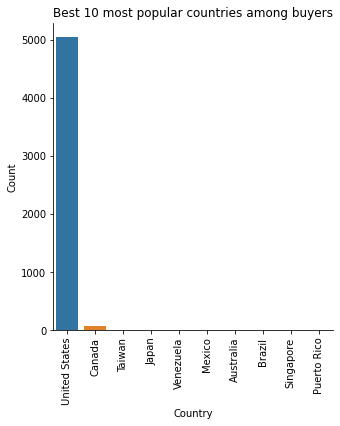

In [43]:
sns.catplot(
    x = 'country',
    data =  buyers,
    kind="count",
    order = buyers['country'].value_counts().iloc[:10].index)
plt.xticks(rotation= 90)
plot_labels('Country','Count','Best 10 most popular countries among buyers')

There are 213 different countries, but only United States is the one that is more frequent. The rest appears with much less frequency, in the general and buyers dataframe, both.

#### City

In [44]:
group_cat(data, 'city')

There are 416 different city.
******************************
                              city   count  percentage
415  not available in demo dataset  228132    0.580648
245                  Mountain View   18152    0.046201
1                        (not set)   13157    0.033488
257                       New York   12458    0.031708
329                  San Francisco    9707    0.024707
209                         London    6231    0.015859
364                      Sunnyvale    6144    0.015638
330                       San Jose    4709    0.011985
210                    Los Angeles    4299    0.010942
89                         Chicago    3476    0.008847


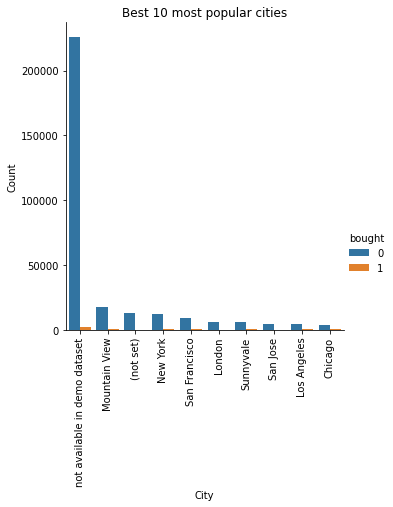

In [45]:
sns.catplot(
    x = 'city',
    data =  data,
    kind="count",
    order = data['city'].value_counts().iloc[:10].index,
    hue = 'bought')
plt.xticks(rotation= 90)
plot_labels('City','Count','Best 10 most popular cities')

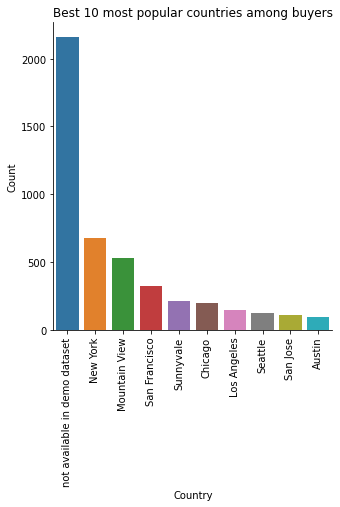

In [46]:
sns.catplot(
    x = 'city',
    data =  buyers,
    kind="count",
    order = buyers['city'].value_counts().iloc[:10].index)
plt.xticks(rotation= 90)
plot_labels('Country','Count','Best 10 most popular countries among buyers')

There are more than 400 different cities, and at least two of these categories are 'not available in demo dataset', and '(not set)' wich are missing values. This category feature is not relevant, because of its dimensionality and the amount of missing values. Also, similar information can be found in the countries column.

### Time Serie, date

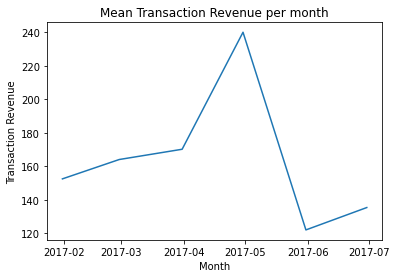

In [47]:
#TransactionRevenue along the six month of data
group_date_M= data.set_index('date').groupby(pd.Grouper(freq='M')).mean()
plt.plot(group_date_M.index, group_date_M['transactionRevenue'])
plot_labels('Month','Transaction Revenue','Mean Transaction Revenue per month')

It can be seen that the month with more revenues is may. But, there are not many years of data to see if there are some kind of pattern.

# Preprocessing




### Columns

Some columns are going to be left behind, and others are going to be change a little.
Numeric columns are going to be left as they are. But categorical are going to be work on.

'Source' is going to be droped and 'channelGrouping' is going to be grouped in less categories, because the last 4 has a little percentage of appearence.

'browser' is going to be left Chrome, Safari and Firefox, the rest are grouped in other.	

'country' is going to be grouped, the first 7 with more frequency of appearence are going to be left as they are, buy the rest are going to be grouped as 'Other'. 'city' column is going to be droped because has similar information as 'country'.

'date' is going to be droped because it doesn't have any pattern.

'fullVisitorID' is the id of each visitor, this is not important in the model.

'transactionRevenue' is not important for predicting transactions, because if we want to know if the user is going to made the transaction, we aren't going to know how much it will be. Also, 'transactions'column is droped because the same reason.


In [48]:
data_droped = data.drop(['fullVisitorID','source', 'city', 'date', 'transactions', 'transactionRevenue'], axis = 1)

data_droped.head()

,visitNumber,bounces,hits,pageviews,timeOnSite,channelGrouping,browser,deviceCategory,country,bought
0,1,1.0,1,1.0,NaN,Organic Search,Chrome,desktop,Australia,0
1,2,1.0,1,1.0,NaN,Organic Search,Chrome,mobile,Turkey,0
2,1,1.0,1,1.0,NaN,Organic Search,Chrome,desktop,Russia,0
3,2,1.0,1,1.0,NaN,Organic Search,Edge,desktop,United States,0
4,1,1.0,1,1.0,NaN,Organic Search,Chrome,desktop,Indonesia,0


#### Channel

In [49]:
data_droped['channelNew'] = np.where(
    (data_droped['channelGrouping'] == 'Paid Search') |  
    (data_droped['channelGrouping'] == 'Affiliates') | 
    (data_droped['channelGrouping'] == 'Display') | 
    (data_droped['channelGrouping'] == '(Other)'), 
    'Other', 
    data_droped['channelGrouping'])

group_cat(data_droped, 'channelNew')

There are 5 different channelNew.
******************************
       channelNew   count  percentage
1  Organic Search  195434    0.497424
0          Direct   73723    0.187642
4          Social   52174    0.132795
3        Referral   48877    0.124403
2           Other   22684    0.057736


#### Browser

In [50]:
data_droped['browserNew'] = np.where(
    (data_droped['browser'] == 'Chrome') |  
    (data_droped['browser'] == 'Safari') | 
    (data_droped['browser'] == 'Firefox'), 
    data_droped['browser'], 
    'Other')

group_cat(data_droped, 'browserNew')

There are 4 different browserNew.
******************************
  browserNew   count  percentage
0     Chrome  279456    0.711279
3     Safari   61638    0.156883
2      Other   33964    0.086446
1    Firefox   17834    0.045392


#### Country


In [51]:
data_droped['countryNew'] = np.where(
    (data_droped['country'] == 'United States') |  
    (data_droped['country'] == 'India') | 
    (data_droped['country'] == 'United Kingdom') |
    (data_droped['country'] == 'Canada') | 
    (data_droped['country'] == 'Germany') | 
    (data_droped['country'] == 'Japan') | 
    (data_droped['country'] == 'France') , 
    data_droped['country'], 
    'Other')

group_cat(data_droped, 'countryNew')

There are 8 different countryNew.
******************************
       countryNew   count  percentage
7   United States  172224    0.438349
5           Other  136150    0.346533
3           India   24361    0.062004
6  United Kingdom   19274    0.049057
0          Canada   12308    0.031327
2         Germany   10467    0.026641
4           Japan    9669    0.024610
1          France    8439    0.021479


In [52]:
data_droped = data_droped.drop(['channelGrouping', 'browser', 'country'], axis = 1)
data_droped.head()

,visitNumber,bounces,hits,pageviews,timeOnSite,deviceCategory,bought,channelNew,browserNew,countryNew
0,1,1.0,1,1.0,NaN,desktop,0,Organic Search,Chrome,Other
1,2,1.0,1,1.0,NaN,mobile,0,Organic Search,Chrome,Other
2,1,1.0,1,1.0,NaN,desktop,0,Organic Search,Chrome,Other
3,2,1.0,1,1.0,NaN,desktop,0,Organic Search,Other,United States
4,1,1.0,1,1.0,NaN,desktop,0,Organic Search,Chrome,Other


### Nulls


In [53]:
def check_nulls(data):
  # Checks wich columns has missing values
  for col in data.columns:
    nuls = data[data[col].isnull()][col].shape[0]
    if nuls != 0:
      per = nuls/data.shape[0] 
      print(col)
      print(f'Amount of nulls:{nuls}')
      print(f'Percentage of nulls: {per}')
      print('**'*6)

In [54]:
check_nulls(data_droped)

bounces
Amount of nulls:196928
Percentage of nulls: 0.5012268002402696
************
pageviews
Amount of nulls:36
Percentage of nulls: 9.162823371308145e-05
************
timeOnSite
Amount of nulls:196493
Percentage of nulls: 0.5001196257495698
************


First bounces column is check, to see if there are mistakes. All NaNs in bounces should be users that had interaction with the site, so pageviews and timeOnSite shouldn't be NaN.

In [55]:
data_bounces_mistake = data_droped[
                                   (
                                    data_droped['pageviews'].isnull() & 
                                    data_droped['bounces'].isnull() & 
                                    data_droped['timeOnSite'].isnull()
                                    )
                                   ]
print(f'There are {data_bounces_mistake.shape[0]} rows with NaN in bounces, pageviews and timeonsite')
data_bounces_mistake.head()

There are 23 rows with NaN in bounces, pageviews and timeonsite


,visitNumber,bounces,hits,pageviews,timeOnSite,deviceCategory,bought,channelNew,browserNew,countryNew
8315,2,NaN,1,NaN,NaN,desktop,0,Organic Search,Chrome,United States
17523,3,NaN,1,NaN,NaN,desktop,0,Referral,Chrome,India
26247,3,NaN,1,NaN,NaN,desktop,0,Other,Firefox,Other
50206,2,NaN,1,NaN,NaN,desktop,0,Referral,Chrome,United States
65382,11,NaN,1,NaN,NaN,desktop,0,Referral,Chrome,United States


There are some of data that in the "bounces" column has NaN (there were interaction), and both "pageviews" and "timeOnSite" also has NaN. This rows are eliminated because the lack of information (big amount of NaNs in those rows).

In [56]:
data_nulls = data_droped[~
                          (
                            data_droped['pageviews'].isnull() & 
                            data_droped['bounces'].isnull() & 
                            data_droped['timeOnSite'].isnull()
                            )
                          ] \
                          .copy()
check_nulls(data_nulls)

bounces
Amount of nulls:196905
Percentage of nulls: 0.5011976002178843
************
pageviews
Amount of nulls:13
Percentage of nulls: 3.308991037725043e-05
************
timeOnSite
Amount of nulls:196470
Percentage of nulls: 0.5000903609091071
************


The 13 rest rows on pageviews that are null are going to be filled in with 1, when pageviews, bounces and time on site are null. This is because if the user didn't bounce (stayed on the site) but quit very soon, many there are NaNs in pageviees and time on site.

In [57]:
data_nulls.loc[
                data_nulls['pageviews'].isnull() & \
                data_nulls['bounces'].isnull() & \
                (data_nulls['timeOnSite'].isnull() == False), 
                'pageviews'] = 1

check_nulls(data_nulls)

bounces
Amount of nulls:196905
Percentage of nulls: 0.5011976002178843
************
timeOnSite
Amount of nulls:196470
Percentage of nulls: 0.5000903609091071
************


Similar analysis, there are 507 rows where "bounces" is NaN (there were interaction), but the time on site were not register. This data are fill with the mean.


In [58]:
time_not_register = data_nulls[
                               data_nulls['timeOnSite'].isnull() & 
                               data_nulls['bounces'].isnull()
                               ]

print(f'There are {time_not_register.shape[0]} rows where bounces is NaN and also time on site')
rows_not_register = data_nulls['timeOnSite'].isnull() & data_nulls['bounces'].isnull()
data_nulls.loc[rows_not_register,'timeOnSite'] = data_nulls['timeOnSite'].mean()
check_nulls(data_nulls)

There are 507 rows where bounces is NaN and also time on site
bounces
Amount of nulls:196905
Percentage of nulls: 0.5011976002178843
************
timeOnSite
Amount of nulls:195963
Percentage of nulls: 0.49879985440439434
************


The rest are filled in with 0, because it is assumed that if there weren't a bounce, then there a 0 in that place (there were a 1 if did).

Is time on site were not registered, then is 0, and the same for transactions.

In [59]:
data_nulls.loc[data_nulls['bounces'].isnull(), 'bounces'] = 0
data_nulls.loc[data_nulls['timeOnSite'].isnull(), 'timeOnSite'] = 0

### Correlation Matrix

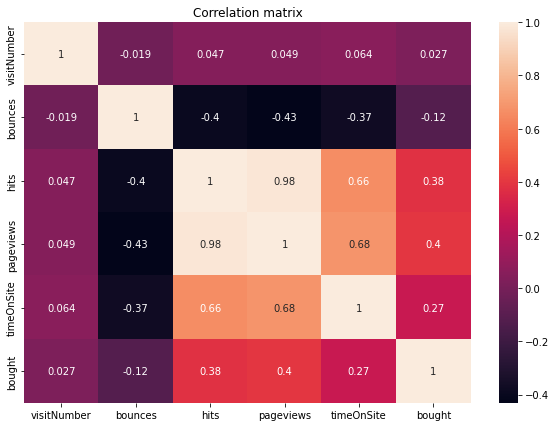

In [60]:
correlation = data_nulls.corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(correlation, ax=ax, annot=True)
ax.set_title('Correlation matrix')
plt.show()

It can be seen that transactions has high correlation with bought, wich is right because there are transactions when the user buys on the site. Also hits and pageviews are high correlated, also making sense because more page  the user sees, more hits it made.

Column hit is going to be droped because of this.
Column bought is the target variable.

In [61]:
data_clean = data_nulls.drop('hits', axis = 1)

### Data split

The data is splited in three sets, train, validation, and test.

In [62]:
y = data_clean['bought']#Split target y features
X = data_clean.drop('bought', axis = 1)
columns_names = X.columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns
print(numerical)
categorical = X.select_dtypes(include=['object']).columns
print(categorical)


Index(['visitNumber', 'bounces', 'pageviews', 'timeOnSite'], dtype='object')
Index(['deviceCategory', 'channelNew', 'browserNew', 'countryNew'], dtype='object')


In [63]:
#train and test split
X_trainVal, X_test, y_trainVal, y_test = train_test_split(
    X,
    y, 
    test_size = 0.3, 
    random_state = 42, 
    stratify = y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainVal,
    y_trainVal, 
    test_size = 0.1, 
    random_state = 42, 
    stratify = y_trainVal
)

In [64]:
# Made them dataframes again to use column transformer
X_train = pd.DataFrame(X_train, 
             columns=columns_names)
X_val = pd.DataFrame(X_val, 
             columns=columns_names)
X_test = pd.DataFrame(X_test, 
             columns=columns_names)

### Preprocessing
Categorical features are encoded with a ordinal encoder, wich puts 0 on the categori with more frequency and 1 to the next and so on.

Numerical features are scaled with standar scaler. Media is turn to cero and standard deviation to one.

In [65]:
t = [('cat', OrdinalEncoder(), categorical), ('num', StandardScaler(), numerical)]
transformer = ColumnTransformer(transformers=t, remainder='passthrough')
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['deviceCategory', 'channelNew', 'browserNew', 'countryNew'], dtype='object')),
                                ('num', StandardScaler(),
                                 Index(['visitNumber', 'bounces', 'pageviews', 'timeOnSite'], dtype='object'))])

In [66]:
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

# Model
This is a problem of skewed data. There are way much more users that didn't buy than that bought. So, this problem is going to be treated as such, the metrics to evaluate are going to be F1-score, precision and recall. This metrics are chosen because the interest is on users that will buy and not, so different strategies con be applied on each one.  Also diferent kind of processes are going to be applied. F1 is a balance between precision and recall, but recall is also important because says is the minority class (pisitive) is being well classified.

In [67]:
group_cat(data_clean,'bought')

There are 2 different bought.
******************************
   bought   count  percentage
0       0  387592    0.986568
1       1    5277    0.013432


In [68]:
# Evaluation function
# This function will be use every time the model is evaluated.
def eval(y_true, y_pred):
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1}')

### Baseline Model

Baseline model with the simplest model of all. This will be done with Logistic Regression. For a model to be the best, must be better than this one.


Train Set
Precision: 0.45720040281973817
Recall: 0.13654135338345866
F1 Score: 0.21028253821213527
************************
Validation Set
Precision: 0.49473684210526314
Recall: 0.12737127371273713
F1 Score: 0.20258620689655174


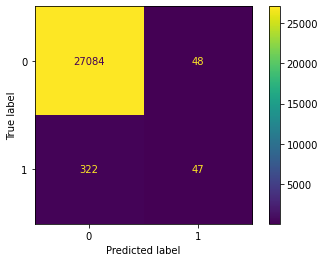

In [69]:
logreg = LogisticRegression(random_state = 42, fit_intercept = True)
logreg.fit(X_train, y_train)

train_base_predict = logreg.predict(X_train)
val_base_predict = logreg.predict(X_val)

print('Train Set')
eval(y_train, train_base_predict)
print('***'*8)
print('Validation Set')
eval(y_val, val_base_predict)

disp = ConfusionMatrixDisplay.from_estimator(
    logreg,
    X_val,
    y_val,
    )


This is a really bad model. The negative class (majority) are being well classified, but the positive class (minority) not.

### Weighted Logistic Regression

This strategy adds a weight on the classes, so the minority class is more penalized and makes less mistakes.

In [70]:
# Weights for each class
weighting = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(y_train), 
    y = y_train)
print(weighting)
class_weights = dict(zip(np.unique(y_train), weighting))
class_weights

[ 0.50680845 37.21909774]


{0: 0.5068084461590125, 1: 37.2190977443609}

Train Set
Precision: 0.17608993693446667
Recall: 0.9657142857142857
F1 Score: 0.29786641929499075
************************
Validation Set
Precision: 0.17536945812807883
Recall: 0.964769647696477
F1 Score: 0.2967903293038766


Text(0.5, 1.0, 'Confusion Matrix')

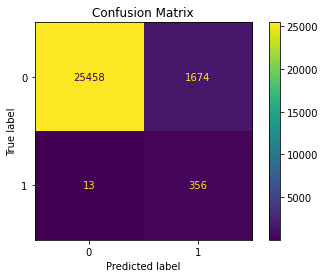

In [71]:
logreg_weighted = LogisticRegression(fit_intercept = True, class_weight = class_weights)
logreg_weighted.fit(X_train,y_train)
pred_train_weighted = logreg_weighted.predict(X_train)
pred_val_weighted = logreg_weighted.predict(X_val)

print('Train Set')
eval(y_train, pred_train_weighted)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_weighted)

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_weighted, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')


In this model, although there are lots of correct minority class, the amount of false positives is too hight, so F1 score gets to be low.

### Another Weighted Logistic Regression

In this case, weights are choosen manually.

Train Set
Precision: 0.26724975704567544
Recall: 0.8270676691729323
F1 Score: 0.4039662137348513
************************
Validation Set
Precision: 0.26229508196721313
Recall: 0.8238482384823849
F1 Score: 0.3979057591623037


Text(0.5, 1.0, 'Confusion Matrix')

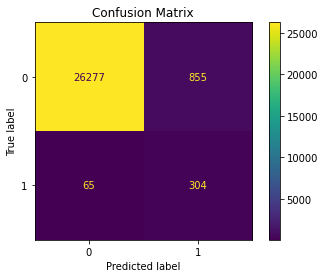

In [72]:
class_weights = {0:1 , 1:20}
logreg_weighted = LogisticRegression(fit_intercept = True, class_weight = class_weights)
logreg_weighted.fit(X_train,y_train)
pred_train_weighted = logreg_weighted.predict(X_train)
pred_val_weighted = logreg_weighted.predict(X_val)

print('Train Set')
eval(y_train, pred_train_weighted)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_weighted)

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_weighted, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')

The F1 score es a little bit higher because there are less false positives. But false negatives are more than in the last model, causing precision to decrease. 

## Undersampling

In this part of the study, the imbalance class problem is going to be mitigated by applying the undersampling strategy.


In [73]:
strategy = 0.2
undersampler = RandomUnderSampler(sampling_strategy = strategy, 
                                  random_state = 42
                                  )
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
label, num = np.unique(y_train_under, return_counts = True)
print(label)
print(num)

[0 1]
[16625  3325]


### Logistic Regression

Train Set
Precision: 0.8575215374420145
Recall: 0.7783458646616541
F1 Score: 0.8160176572599716
************************
Validation Set
Precision: 0.27586206896551724
Recall: 0.7371273712737128
F1 Score: 0.40147601476014755


Text(0.5, 1.0, 'Confusion Matrix')

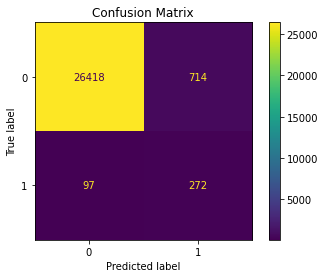

In [74]:
logreg_under = LogisticRegression(fit_intercept = True)
logreg_under.fit(X_train_under,y_train_under)
pred_train_under = logreg_under.predict(X_train_under)
pred_val_under = logreg_under.predict(X_val)

print('Train Set')
eval(y_train_under, pred_train_under)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_under)

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_under, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')

Metrics in train set are good, but when testing on validation dataset they get bad. This is overfitting. We try to solve it whit reguralization on the logistic regression.

Train Set
Precision: 0.8613691090471276
Recall: 0.7530827067669172
F1 Score: 0.8035943517329909
************************
Validation Set
Precision: 0.27471383975026015
Recall: 0.7154471544715447
F1 Score: 0.39699248120300756


Text(0.5, 1.0, 'Confusion Matrix')

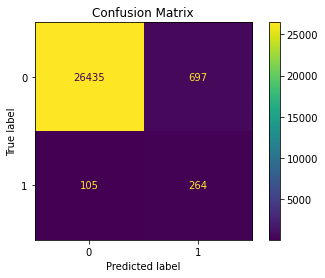

In [75]:
logreg_reg = LogisticRegression(fit_intercept = True,
                                random_state = 42,
                                C = 0.01)
logreg_reg.fit(X_train_under,y_train_under)
pred_train_reg = logreg_reg.predict(X_train_under)
pred_val_reg = logreg_reg.predict(X_val)

print('Train Set')
eval(y_train_under, pred_train_reg)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_reg)

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_reg, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')

Logistic regression doesn't seems to get better. Another algorithm is tested.

### Gradient Boosted Trees


Train Set
Precision: 0.859139183901621
Recall: 0.9245112781954887
F1 Score: 0.8906272635086194
************************
Validation Set
Precision: 0.27887788778877887
Recall: 0.9159891598915989
F1 Score: 0.4275774826059456


Text(0.5, 1.0, 'Confusion Matrix')

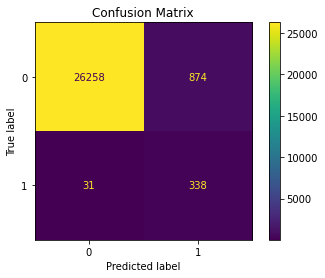

In [76]:
gbt = GradientBoostingClassifier(random_state = 42, 
                                 n_estimators = 100, 
                                 max_depth = 3)
gbt.fit(X_train_under, y_train_under)
pred_train_gbt_under = gbt.predict(X_train_under)
pred_val_gbt_under = gbt.predict(X_val)
print('Train Set')
eval(y_train_under, pred_train_gbt_under)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_gbt_under)

disp = ConfusionMatrixDisplay.from_estimator(
    gbt, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')

As far, this is the best model, but not good enough.
Lets try another technic to mitigate imbalanced classes.

## SMOTE

SMOTE algorith creates similar samples on the minority class, to reduce de imbalance if the problem.

In [77]:
strategy = 0.2
oversample = SMOTE(sampling_strategy = strategy, 
                   random_state = 42
                   )
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)
label, number = np.unique(y_train_SMOTE, return_counts = True)
print(label)
print(number)

[0 1]
[244182  48836]


Train Set
Precision: 0.8805130045520654
Recall: 0.9545622082070604
F1 Score: 0.9160435846294424
************************
Validation Set
Precision: 0.3176823176823177
Recall: 0.8617886178861789
F1 Score: 0.4642335766423358


Text(0.5, 1.0, 'Confusion Matrix')

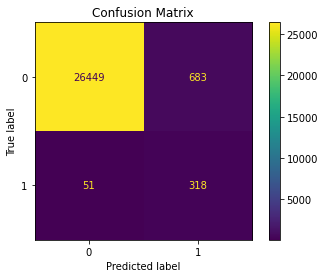

In [78]:
gbt_smote = GradientBoostingClassifier(random_state = 42, 
                                 n_estimators = 100, 
                                 max_depth = 3
                                 )
gbt_smote.fit(X_train_SMOTE, y_train_SMOTE)
pred_train_gbt_SMOTE = gbt_smote.predict(X_train_SMOTE)
pred_val_gbt_SMOTE = gbt_smote.predict(X_val)
print('Train Set')
eval(y_train_SMOTE, pred_train_gbt_SMOTE)
print('***'*8)
print('Validation Set')
eval(y_val, pred_val_gbt_SMOTE)

disp = ConfusionMatrixDisplay.from_estimator(
    gbt_smote, 
    X_val, 
    y_val
)
disp.ax_.set_title('Confusion Matrix')

This is the best model so far. Precision in validation set is still low, because there are a lot of false positives. But, the F1 score is the higher.

To see how this model behaves with totally new data, it is evaluated on the test set.

In [79]:
pred_test_gbt_SMOTE = gbt_smote.predict(X_test)
print('Test Set')
eval(y_test, pred_test_gbt_SMOTE)

Test Set
Precision: 0.31520507591207797
Recall: 0.8787113076437144
F1 Score: 0.46397598398932616


Text(0.5, 1.0, 'Confusion Matrix')

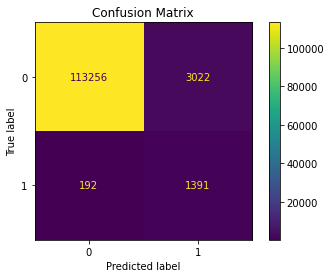

In [80]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbt_smote, 
    X_test, 
    y_test
)
disp.ax_.set_title('Confusion Matrix')

# Conclusions

In this study a classification model to predict wich users are going to buy or not on the site with google analytics dataset where made. This is an unbalanced classification model, because only 0.01% of the samples are the positive class (user that made a transaction on the site).

An exporatory data analysis where made on the dataset, seeing that most buyers where the ones that expend more time on the site, made more hits... In general, the ones that made more interaction and also the ones that where a little beyond the majority of the samples where the ones that bought on the site.

A baseline model with a Logistic Regresion algorithm were made, with this metrics on the validation dataset:

Precision: 0.4947

Recall: 0.1273

F1 Score: 0.2025

Recall is the most important metric, because we want the best amount of true positives possible. But also precision can't be very low, because that would mean than there were many false positives.

Lots of algoritms where tested for this problem and technics for reducing the imbalance problem where implemented, being SMOTE the best of all.
The best model was a Gradient Boosted Trees algorithm with the SMOTE approach. The metrics for this solution on the validation set were:

Precision: 0.3176

Recall: 0.8617

F1 Score: 0.4642

Although precision is a little bit smaller, recall and f1 score are way greater tan the baseline model, wich means that in this last model more minority class were well classified, not making too much difference in the majority class.

The metrics for this model on the test set were very similar, so we conclude this model would behave well with new unseen data.
